In [112]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [3]:
data = pd.read_csv('owid-covid-data.csv')

In [172]:
Russia = data[data['location']=='Russia'][['date','new_cases','total_cases']]

In [173]:
Russia = Russia[pd.to_datetime(Russia['date']) >= pd.to_datetime('2020-03-03')]

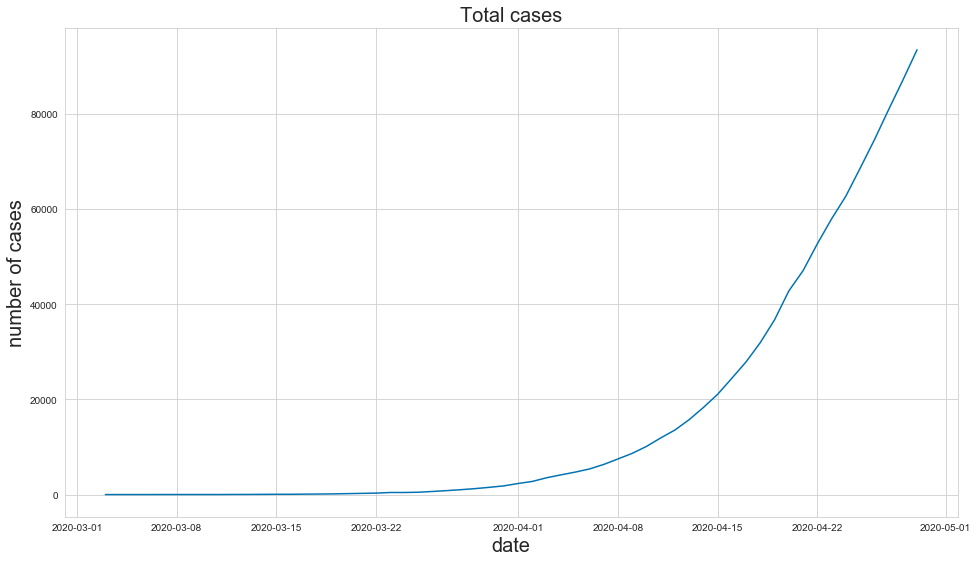

In [39]:
plt.figure(figsize=(16,9))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),Russia['total_cases']);

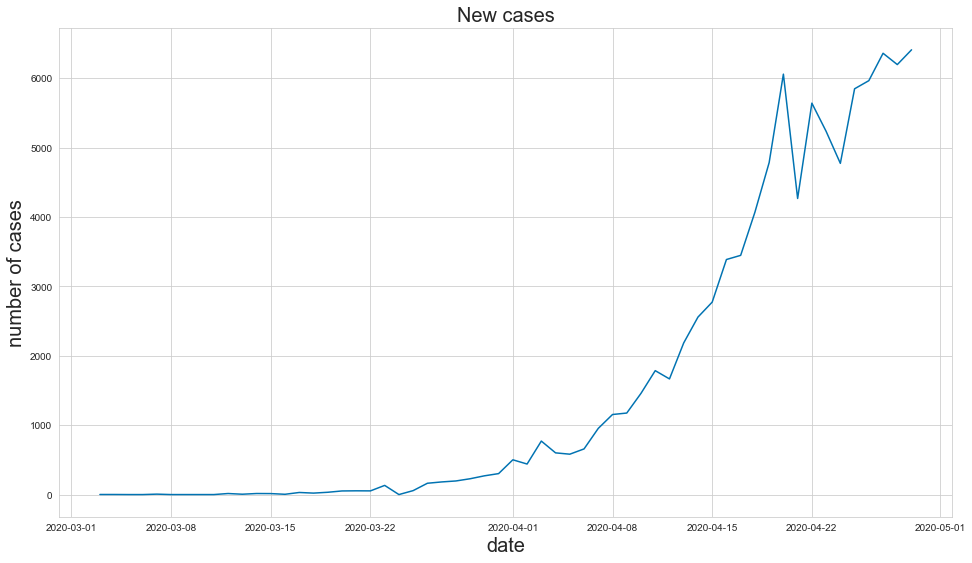

In [43]:
plt.figure(figsize=(16,9))
plt.title('New cases',fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),Russia['new_cases']);

In [49]:
train = Russia[:50]
test = Russia[50:]

In [151]:
y_train = np.log(train['total_cases'])
y_test = np.log(test['total_cases'])
X_train = pd.to_datetime(train['date'])-pd.to_datetime('2020-03-03')
X_train = np.array([X_train.apply(lambda x: x.days)]).T
X_test = pd.to_datetime(test['date'])-pd.to_datetime('2020-03-03')
X_test = np.array([X_test.apply(lambda x: x.days)]).T
X_all = np.concatenate([X_train,X_test], axis = 0)
y_all = np.concatenate([y_train,y_test], axis = 0)

linear_regression = LinearRegression().fit(X_train,y_train)

MSE train: 0.128772948328438
MSE test: 1.4776729988064767
MSE train (in terms of exp):  89876671.94553281
MSE test (in terms of exp):  45320538466.77417


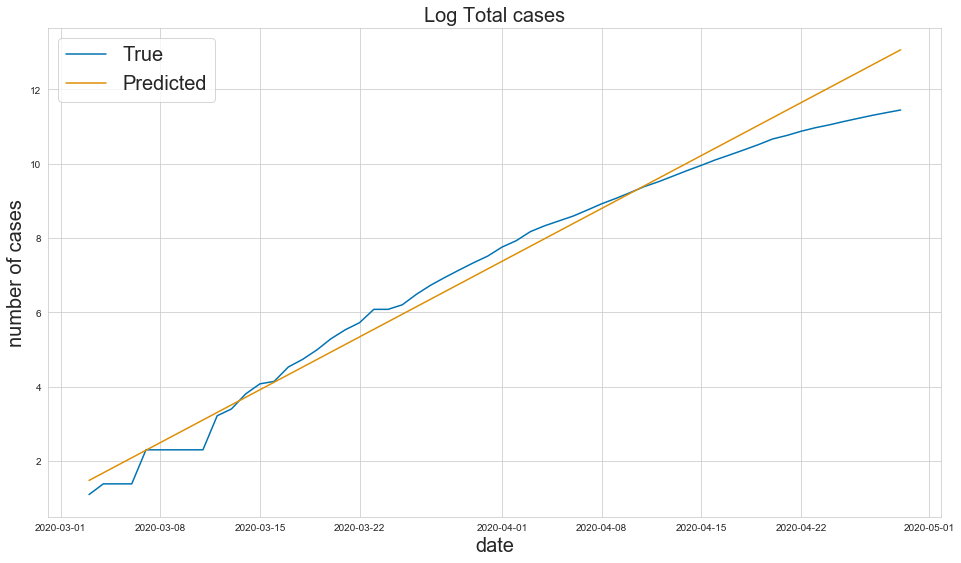

In [152]:
print('MSE train:',mse(linear_regression.predict(X_train),y_train))
print('MSE test:',mse(linear_regression.predict(X_test),y_test))
print('MSE train (in terms of exp): ', mse(np.exp(linear_regression.predict(X_train)),np.exp(y_train)))
print('MSE test (in terms of exp): ', mse(np.exp(linear_regression.predict(X_test)),np.exp(y_test)))
plt.figure(figsize=(16,9))
plt.title('Log Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),np.log(Russia['total_cases']), label = 'True');
plt.plot(pd.to_datetime(Russia['date']),linear_regression.predict(X_all), label = 'Predicted')
plt.legend(fontsize = 20);

### Как будем обучать модель сигмоиды?

Мы пытаемся подогнать набор точек, гауссианой умноженной на константу\
Заметим $(a\Phi_{\mu,\sigma^2}(x))'= $ новые случаи заражения короновирусом за маленький период \
Тем самым мы можем найти апроксимацию через МНК на данных новых случаях заражения для $\Phi(x)'$, а затем перейти за счет куммулятивной суммы к прогнозу число зараженных\
Пусть $y_i = (a\Phi_{\mu,\sigma^2}(x_i))' = \frac{a}{\sqrt{2\pi}\sigma}e^{-(x-\mu)^2/(2\sigma^2)}$\
Перейдем к $\ln y_i$ \
$\ln y_i = \ln a - \ln\sqrt{2\pi}\sigma + \frac{-(x-\mu)^2}{2\sigma^2}$\
$\ln y_i = \ln a - \ln\sqrt{2\pi}\sigma - \frac{x^2}{2\sigma^2} + \frac{x\mu}{\sigma^2} - \frac{\mu^2}{2\sigma^2}$\
Видим, что мы пытаемся предсказать $\ln y$ квадратичным многочленом $w_2 x^2 + w_1 x + w_0$.\

In [153]:
y_train = np.log(train['new_cases']).apply(lambda x: max(x,0))
y_test = np.log(test['new_cases']).apply(lambda x: max(x,0))
X_train = pd.to_datetime(train['date'])-pd.to_datetime('2020-03-03')
X_train = np.array([X_train.apply(lambda x: x.days),X_train.apply(lambda x: x.days ** 2)]).T
X_test = pd.to_datetime(test['date'])-pd.to_datetime('2020-03-03')
X_test = np.array([X_test.apply(lambda x: x.days), X_test.apply(lambda x: x.days ** 2)]).T
X_all = np.concatenate([X_train,X_test], axis = 0)
y_all = np.concatenate([y_train,y_test], axis = 0)

C:\Users\Sali1\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [154]:
linear_regression = LinearRegression().fit(X_train,y_train)

MSE train: 0.6215416799355634
MSE test: 0.40204072291774434


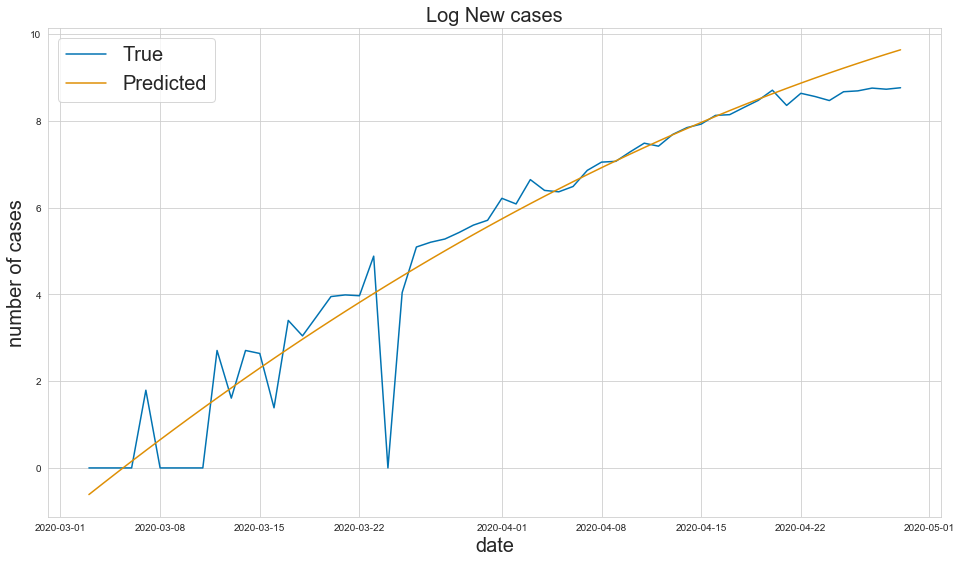

In [155]:
print('MSE train:',mse(linear_regression.predict(X_train),y_train))
print('MSE test:',mse(linear_regression.predict(X_test),y_test))
plt.figure(figsize=(16,9))
plt.title('Log New cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(Russia['date']),np.log(Russia['new_cases'].apply(lambda x: max(1,x))), label = 'True')
plt.plot(pd.to_datetime(Russia['date']),linear_regression.predict(X_all), label = 'Predicted')
plt.legend(fontsize = 20);

In [165]:
def com_sum(ar,i):
    s = 0
    for i in range(i):
        s = s + ar[i]
    return s
n = 200
Predicted = linear_regression.predict(np.array([np.arange(200),np.arange(200)**2]).T)
simoid = [com_sum(np.exp(Predicted),i) for i in range(200)]

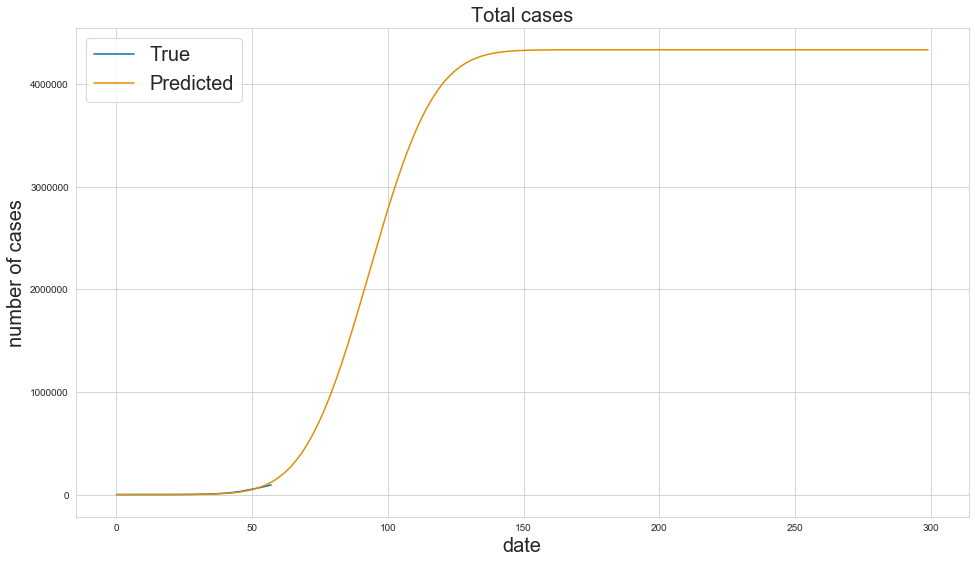

In [168]:
plt.figure(figsize=(16,9))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(np.arange(len(Russia['total_cases'])),Russia['total_cases'], label = 'True');
plt.plot(np.arange(n),simoid, label = 'Predicted')
plt.legend(fontsize = 20);

In [174]:
China = data[data['location']=='China'][['date','new_cases','total_cases']]

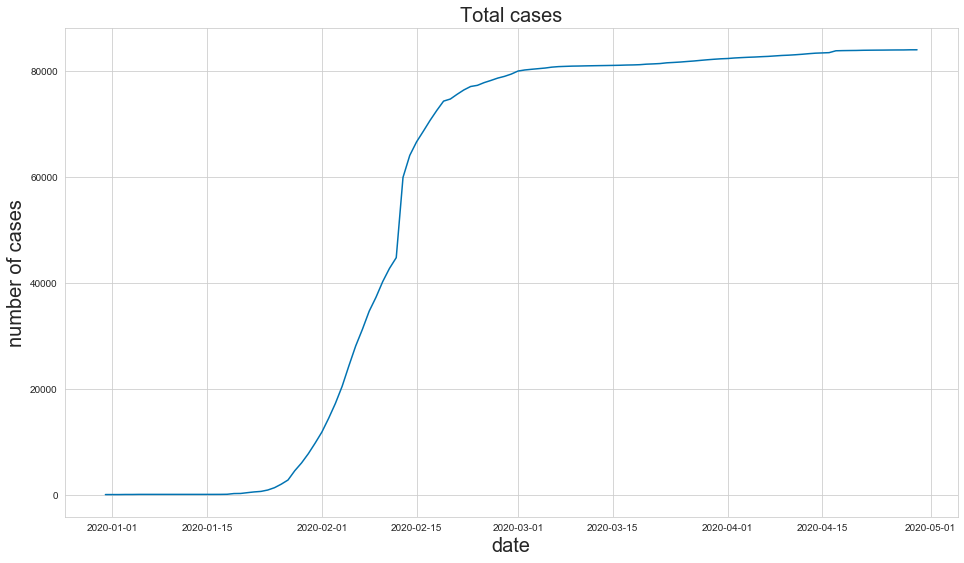

In [175]:
plt.figure(figsize=(16,9))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(China['date']),China['total_cases']);

In [251]:
train = China[:70]
test = China[70:]

In [252]:
y_train = np.log(train['new_cases']).apply(lambda x: max(x,0))
y_test = np.log(test['new_cases']).apply(lambda x: max(x,0))
X_train = pd.to_datetime(train['date'])-pd.to_datetime('2019-12-31')
X_train = np.array([X_train.apply(lambda x: x.days),X_train.apply(lambda x: x.days ** 2)]).T
X_test = pd.to_datetime(test['date'])-pd.to_datetime('2019-12-31')
X_test = np.array([X_test.apply(lambda x: x.days), X_test.apply(lambda x: x.days ** 2)]).T
X_all = np.concatenate([X_train,X_test], axis = 0)
y_all = np.concatenate([y_train,y_test], axis = 0)

C:\Users\Sali1\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [253]:
linear_regression = LinearRegression().fit(X_train,y_train)

MSE train: 2.1425734286826668
MSE test: 165.1114986754117


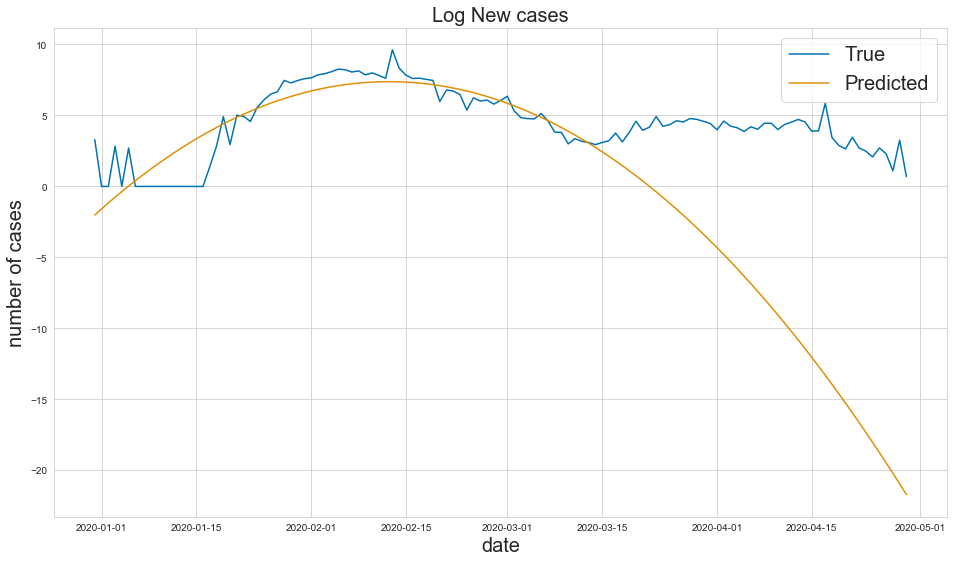

In [254]:
print('MSE train:',mse(linear_regression.predict(X_train),y_train))
print('MSE test:',mse(linear_regression.predict(X_test),y_test))
plt.figure(figsize=(16,9))
plt.title('Log New cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(pd.to_datetime(China['date']),np.log(China['new_cases'].apply(lambda x: max(1,x))), label = 'True')
plt.plot(pd.to_datetime(China['date']),linear_regression.predict(X_all), label = 'Predicted')
plt.legend(fontsize = 20);

In [255]:
n = 100
Predicted = linear_regression.predict(np.array([np.arange(n),np.arange(n)**2]).T)
simoid = [com_sum(np.exp(Predicted),i) for i in range(n)]

In [256]:
China['total_cases']

2460       27
2461       27
2462       27
2463       44
2464       44
        ...  
2576    83899
2577    83909
2578    83912
2579    83938
2580    83940
Name: total_cases, Length: 121, dtype: int64

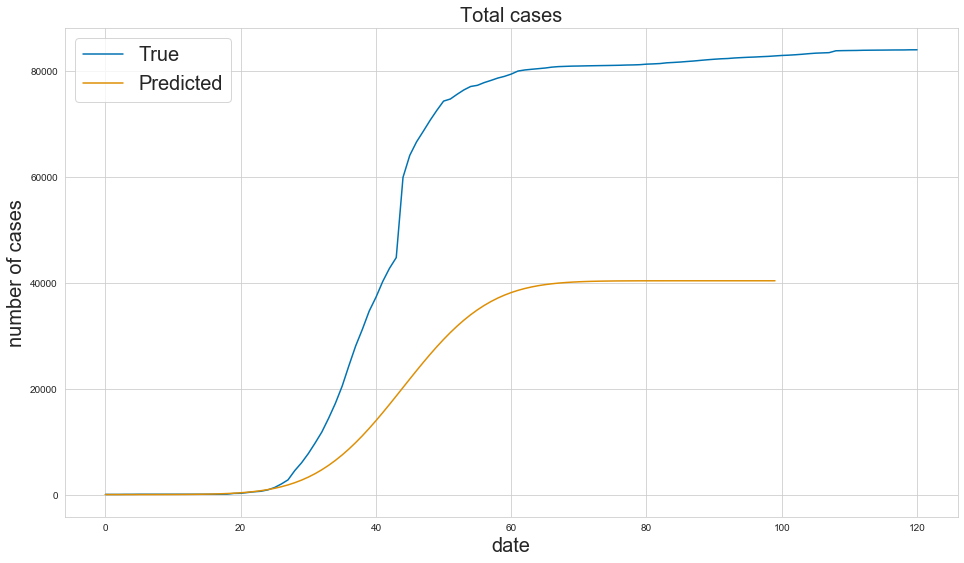

In [257]:
plt.figure(figsize=(16,9))
plt.title('Total cases', fontsize=20)
plt.xlabel('date', fontsize=20)
plt.ylabel('number of cases', fontsize=20)
plt.plot(np.arange(len(China['total_cases'])),China['total_cases'], label = 'True');
plt.plot(np.arange(n),simoid, label = 'Predicted')
plt.legend(fontsize = 20);